In [1]:
import geopandas as gpd
from shapely.geometry import Point
from fiona.crs import from_epsg
import numpy as np

import glob, requests, json, re, netrc

from matplotlib.colors import LogNorm, Normalize

In [2]:
all_scans = []
all_detections = []

for f in glob.glob("scans/*json"):
    
    fi = int(re.sub(r"scans\/([0-9]{5}).json", r"\1", f))

    with open(f) as obj: j = json.load(obj)

    df = pd.DataFrame(j["bssid"])
    df.rename(columns = {"macAddress" : "bssid",
                         "signalStrength" : "rssi"}, 
              inplace = True)

    df["scan"] = fi
    df["lat"]  = j["lat"]
    df["lon"]  = j["lon"]
    
    all_scans.append([j["lat"], j["lon"], len(j["bssid"])])
    all_detections.append(df)
    
all_scans = pd.DataFrame(columns = ["lat", "lon", "N"], 
                              data = all_scans)

geom = gpd.GeoSeries([Point(xy) for xy in zip(all_scans.lon, all_scans.lat)], 
                     crs = from_epsg(4326)).to_crs(epsg = 3528)

all_scans = gpd.GeoDataFrame(data = all_scans, geometry = geom, crs = from_epsg(3528))


all_detections = pd.concat(all_detections, sort = False)
all_detections.sort_values(by = ["bssid", "rssi"], inplace = True)
all_detections.query("bssid != '00:00:00:00:00:00'", inplace = True)
all_detections.reset_index(inplace = True, drop = True)

geom = gpd.GeoSeries([Point(xy) for xy in zip(all_detections.lon, 
                                              all_detections.lat)], 
                     crs = from_epsg(4326)).to_crs(epsg = 3528)

all_detections = gpd.GeoDataFrame(data = all_detections, 
                                  geometry = geom, crs = from_epsg(3528))

#### Street network for Hyde Park

In [3]:
xmin, xmax = 362000, 363000
ymin, ymax = 569600, 570300

In [4]:
# %%bash

# wget -nv 'https://overpass-api.de/api/interpreter?data=(way["highway"](41.7911187,-87.5909545,41.8113041,-87.5656831);way["railway"](41.7911187,-87.5909545,41.8113041,-87.5656831););out body;>;out skel qt;' -O ways.osm
# ogr2ogr --config OSM_USE_CUSTOM_INDEXING NO -f GeoJSON streets.geojson  ways.osm  lines

Save some levels for the importance of various ways.

In [1]:
streets = gpd.read_file("streets.geojson")
streets = streets[streets.centroid.x < -80]
streets.to_crs(epsg = 3528, inplace = True)

level = {'motorway' : 1, 'motorway_link' : 1,
         'trunk' : 1, 'trunk_link' : 1,
         'primary' : 1, 'primary_link' : 1,
         'secondary' : 1, 'secondary_link' : 1,
         'tertiary' : 2, 'tertiary_link' : 2,
         'residential' : 3,
         'service' : 4.5, 'footway' : 4, 'path' : 4, 
         'steps' : 4, 'cycleway' : 4, 'pedestrian' : 4, 
         None: 5}

streets["highway_level"] = streets.highway.replace(level)
streets["highway_thickness"] = 5 - streets["highway_level"]

streets.to_file("streets_lw.geojson", driver = "GeoJSON")

/Users/jsaxon/anaconda/envs/py-geo/lib/python3.6/site-packages/geopandas/io/file.py:62: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


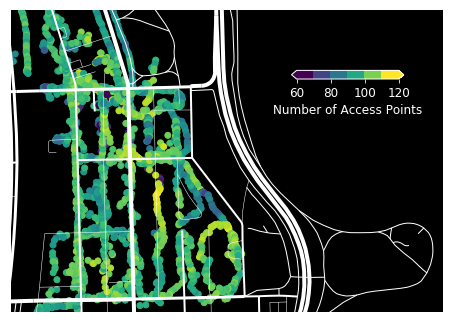

In [6]:
fig, ax = plt.subplots(figsize = (6, 6), subplot_kw = {"aspect" : "equal"})

vmin, vmax, vsteps = 60, 120, 6

cmap = discretize_colormap("viridis", vsteps)
all_scans.plot(column = "N", ax = ax, vmin = vmin, vmax = vmax)

streets  .plot(color  = "w", ax = ax, lw = streets.highway_thickness)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_facecolor("k")

map_format(ax)

add_cmap(fig, cmap, 
         text = "Number of Access Points", 
         location = [0.65, 0.69, 0.26, 0.02], 
         ticks = [60, 80, 100, 120],
         invert_colors = True, vmin = vmin, vmax = vmax)

fig.savefig("wifi_walk.pdf", facecolor = "k", edgecolor='none', 
            bbox_inches='tight', pad_inches=0.025, linewidth = 3, dpi = 150)

fig.savefig("wifi_walk.png", facecolor = "k", edgecolor='none', 
            bbox_inches='tight', pad_inches=0.025, linewidth = 3, dpi = 300)

#### How many unique BSSIDs?

Note that there are often many on a single router, e.g., for xfinitywifi and perhaps multiple channels.  They typically vary by just a few digits on the BSSID.

In [7]:
len(all_detections.bssid.unique())

10006

In [8]:
all_detections_U = all_detections.dissolve("bssid")[["geometry"]]
all_detections_U.set_geometry(all_detections_U.centroid, inplace = True)

In [17]:
all_detections.sort_values(by = ["bssid", "rssi"], ascending = [True, False], inplace = True)
all_detections_U = all_detections.drop_duplicates("bssid", keep = "first")

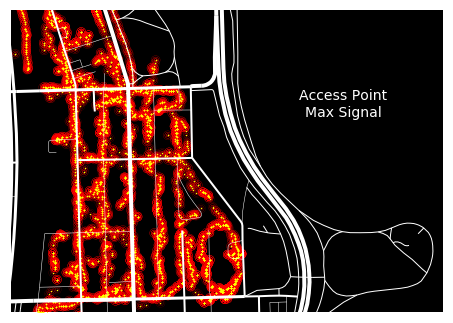

In [20]:
fig, ax = plt.subplots(figsize = (6, 6), subplot_kw = {"aspect" : "equal"})

all_detections_U.plot(facecolor = "none", alpha = 0.75, edgecolor = "r", markersize = 3**2, linewidth = 0.4, ax = ax)
all_detections_U.plot(facecolor = "none", alpha = 0.50, edgecolor = "r", markersize = 6**2, linewidth = 0.4, ax = ax)
all_detections_U.plot(facecolor = "none", alpha = 0.25, edgecolor = "r", markersize = 9**2, linewidth = 0.4, ax = ax)
all_detections_U.plot(color = "#ffff00", alpha = 1.0, markersize = 2, linewidth = 0, ax = ax)


streets.plot(color = "w", lw = streets.highway_thickness, ax = ax)

ax.text(x = 0.77, y = 0.65, s = "Access Point\nMax Signal", size = 14,
        horizontalalignment = "center",
        transform=ax.transAxes, color = "w")

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_facecolor("k")

map_format(ax)

fig.savefig("wifi_max.pdf", facecolor = "k", edgecolor='none', 
            bbox_inches='tight', pad_inches=0.025)

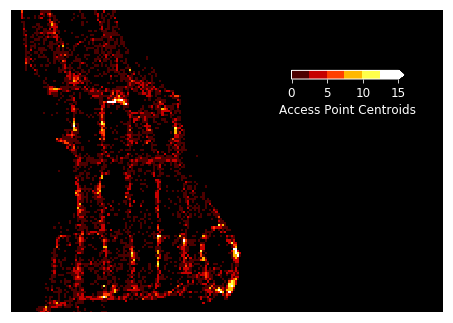

In [14]:
fig, ax = plt.subplots(figsize = (6, 6), subplot_kw = {"aspect" : "equal"})

H, xedges, yedges = \
  np.histogram2d(all_detections_U.geometry.x, 
                 all_detections_U.geometry.y,
                 bins = (np.arange(xmin, xmax + 0.01, 5),
                         np.arange(ymin, ymax + 0.01, 5)))

H = np.ma.masked_array(H, mask = H == 0)

X, Y = np.meshgrid(xedges, yedges)

vmin, vmax, vsteps = 0, 15, 6
norm = Normalize(vmin = vmin, vmax = vmax)

cmap = truncate_colormap(cm.get_cmap("hot"), 0.1, 1)
cmap = discretize_colormap(cmap, vsteps)
cmap.set_bad('k', 1)

im = ax.pcolormesh(X, Y, H.T, cmap = cmap, norm = norm)

map_format(ax)

add_cmap(fig, cmap, 
         text = "Access Point Centroids", 
         location = [0.65, 0.69, 0.26, 0.02], 
         ticks = range(0, 16, 5),
         invert_colors = True, vmin = vmin, vmax = vmax)

fig.savefig("wifi_histo.pdf", facecolor = "k", edgecolor='none', 
            bbox_inches = 'tight', pad_inches=0.025, dpi = 300)

fig.savefig("wifi_histo.png", facecolor = "k", edgecolor='none', 
            bbox_inches = 'tight', pad_inches=0.025, dpi = 300)

Alternate strategy is to just send every one of these to google individually.  Realistically, this would not be very expensive and it would be more accurate.  Is it necessary?

#### Try asking Google for the location of a single device...

In [11]:
from wifi_mapping import *

with open("scans/00001.json") as obj: j = json.load(obj)

It doesn't respond.

In [12]:
j["bssid"][:2]

[{'macAddress': '3c:b7:4b:8c:ac:9d', 'signalStrength': -39},
 {'macAddress': '3c:b7:4b:8c:ac:9b', 'signalStrength': -40}]

In [13]:
get_location(addresses = j["bssid"][:1])

NameError: name 'get_location' is not defined

But of course we can sometimes cheat and ask about multiple BSSIDs on the same physical device.

In [ ]:
js = sorted(j["bssid"], key = lambda x : x["macAddress"])

js = [jsi for jsi in js if "a0:0d:cb:8c" in jsi["macAddress"]]
js

In [ ]:
get_location(addresses = js)

In [ ]:
fig, ax = plt.subplots(figsize = (6, 6), subplot_kw = {"aspect" : "equal"})

streets.plot(color = "k", lw = streets.highway_thickness, ax = ax)

gs = gpd.GeoSeries([Point(-87.5843, 41.7993318)], 
                   crs = from_epsg(4326)).to_crs(epsg = 3528)

gs.plot(ax = ax, marker = "*", markersize = 150, color = "red")

ax.set_xlim(362000, 363000)
ax.set_ylim(569600, 570300)

map_format(ax)

Home sweet home, kitchen window...